# Introduction to vector databases

In this exercise you will learn how vector databases are used to store text. 

Text is converted to vectors through the use of an `embedding model`. An embedding model is a large language model that is designed to create vectors out of chunks of text. It is these vectors that will be stored in the database.

For the lab we will be using Milvus for our vector database.

### Step 1: Setup Environment

Install the required Python packages listed in `requirements.txt` to ensure all dependencies for the lab are available.

In [1]:
# Step 1: Install necessary libraries (run in a cell if needed)
!uv pip install -r requirements.txt

Using Python 3.11.11 environment at: /opt/app-root
Audited 10 packages in 21ms


### Step 2: Import Required Libraries

The following code block imports all necessary Python libraries and packages that will be used throughout this lab, including Milvus client, embedding model, and analysis tools.

In [2]:
# Milvus client for vector database operations
from pymilvus import connections, utility, Collection, CollectionSchema, FieldSchema, DataType
# SentenceTransformer for generating text embeddings
from sentence_transformers import SentenceTransformer
# Cosine similarity metric for embedding comparison
from sklearn.metrics.pairwise import cosine_similarity
# NumPy for numerical computations
import numpy as np
# Matplotlib for visualization
import matplotlib.pyplot as plt
# PCA for dimensionality reduction
from sklearn.decomposition import PCA

/opt/app-root/lib64/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Create the vector database

### Step 3: Create the Vector Database

In this step, we will connect to Milvus, define a collection schema, and create a new collection to store our text embeddings. The schema includes an integer ID and a float vector field for the embeddings.  

The length of the vectors that are stored in the vector database must support the the chosen embedding model. For this lab we have chosen is `"all-MiniLM-L6-v2"` which has 385 dimensions. There are many sifferent embedding models available on Hugging Face. The best way to assess them for your task is to review the **[Embedding LLM Leaderboard](https://huggingface.co/spaces/mteb/leaderboard)**.  

As you can see from the diagram below, `all-MiniLM-L6-v2` is not the best embedding model, but for its size it is one of the best in class models. We selected it for this lab because it will download and run faster for you.

<img src="https://raw.githubusercontent.com/odh-labs/rhoai-roadshow-v2/rag-dev/docs/2-rag/images/simple-rag-1.png" width=50%/>

In [3]:
# Define the Milvus collection name that will store our embeddings
collection_name = "vectordb_collection"  # Unique identifier for vector store

# Establish connection to Milvus vector database service
connections.connect(
    uri="http://milvus-service.milvus.svc.cluster.local:19530",  # Milvus server endpoint
    alias="default"  # Alias to reference this connection in later operations
)

In [4]:
# Remove any existing collection with the same name to start fresh
if utility.has_collection(collection_name):
    utility.drop_collection(collection_name)

# Display current collections to verify deletion
print(f"Collection list after cleanup: {utility.list_collections()}")

Collection list after cleanup: []


In [5]:
# Databases need a schema. In this lab the schema will consist 
# of an identifier and a vector that contains the embedding of a text string.

# Define the primary key field for unique record identification
id_field = FieldSchema(
    name="id",
    dtype=DataType.INT64,
    is_primary=True,
    auto_id=False
)

# Specify embedding model and its output dimension
embedding_model = "all-MiniLM-L6-v2"  # Example Hugging Face model
embedding_dim = 384  # Embedding vector size as per the model

# Define the vector field to hold embedding values
embedding_field = FieldSchema(
    name="embedding",
    dtype=DataType.FLOAT_VECTOR,
    dim=embedding_dim
)

# Assemble collection schema combining ID and embedding fields
schema = CollectionSchema(
    fields=[id_field, embedding_field],
    description="Milvus shakeout test",
    enable_dynamic_field=False
)

In [6]:
# Instantiate the Milvus collection using the defined schema and configuration
collection = Collection(
    name=collection_name, 
    schema=schema, 
    using='default', 
    shards_num=2,
    consistency_level="Strong"
)

# Display the collection schema that was just created
print(f"Collection: {collection.schema}\n")

# List all collections in Milvus to confirm creation
print(f"Collection list: {utility.list_collections()}")

Collection: {'auto_id': False, 'description': 'Milvus shakeout test', 'fields': [{'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': False}, {'name': 'embedding', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 384}}], 'enable_dynamic_field': False}

Collection list: ['vectordb_collection']


In [7]:
# Generate embeddings using a simple embedding model from Hugging Face 
model = SentenceTransformer(embedding_model)

## Create test data for the vector database

### Step 4: Generate Embeddings and Create Test Data

In this step, we use a Hugging Face embedding model to convert text terms into high-dimensional vectors that will be stored in the database.

## Test data retrieval

### Step 5: Test Data Retrieval

In this step, we define a function to search the collection using an embedding and retrieve the most similar items based on cosine similarity.

In [8]:
# Prove we can retrieve data from the database
def search(term):
    vector = model.encode([term])
    results = collection.search(vector, "embedding", param={"metric_type": "COSINE"}, limit=3)
    return results

### Step 6: Visualize Embeddings

Here we reduce the high-dimensional embeddings to 2D using PCA and plot the terms to observe their relative positions and relationships.

Observe that dog and cat are more similar than dog and pumpkin

# 🧠 Text Embeddings: Converting Words to Vectors

## What Are Text Embeddings?

Text embeddings are numerical representations of text that capture semantic meaning. Think of them as coordinates in a high-dimensional space where similar concepts are located close to each other.

### Key Concepts:

- **Vector Space**: Each word or phrase becomes a point in multidimensional space
- **Semantic Similarity**: Similar texts have similar vector representations
- **Distance Metrics**: We can measure how "close" two texts are using mathematical distance
- **Dense Representation**: Unlike sparse representations (like one-hot encoding), embeddings are dense vectors

### Why Use Embeddings in RAG?

1. **Semantic Search**: Find documents by meaning, not just keyword matching
2. **Context Understanding**: Capture relationships between concepts
3. **Efficiency**: Enable fast similarity comparisons using vector operations
4. **Generalization**: Handle synonyms and related concepts automatically

### The Model We're Using: all-MiniLM-L6-v2

This is a popular sentence embedding model that:
- **Balances Performance and Speed**: Good quality embeddings with fast inference
- **Sentence-Level**: Optimized for encoding entire sentences or paragraphs
- **384 Dimensions**: Compact representation that's efficient for storage and search
- **Multilingual**: Supports multiple languages out of the box

Let's initialize our embedding model and explore how it works!

## 🔬 Understanding Embedding Dimension and Semantic Similarity Exploration

This section is designed to **demonstrate how text embeddings work** and illustrate two key educational goals:

1. **Understanding the structure and dimensionality of embedding vectors**
2. **Evaluating how embeddings capture semantic meaning**

These insights are foundational for configuring and using a **vector database** in Retrieval-Augmented Generation (RAG) systems or semantic search.

---

## 🧪 Purpose of the Code

### 1. Embedding Output Inspection
The first half of the code runs a test on the embedding function (`model.encode`) using a simple sentence:

```python
test_text = "This is a test sentence to demonstrate text embeddings."
test_embedding = model.encode(test_text)
```

## 2. 📌 Similarity Scores and Educational Highlight
Pay attention to the similarity scores printed for the weather-related vs unrelated sentences.
You should see a higher similarity score for the related pair, which illustrates how embeddings can meaningfully represent the semantic closeness of two pieces of text.
This capability underpins search relevance in vector databases.


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ===== EMBEDDING DIMENSION EXPLORATION =====
# Test our embedding function to understand the output format and dimensions
# This information is crucial for configuring the vector database schema

print("🧪 Testing embedding function with sample text...")
test_text = "This is a test sentence to demonstrate text embeddings."
test_embedding = model.encode(test_text)
embedding_dim = len(test_embedding)

print(f"📊 EMBEDDING ANALYSIS:")
print(f"   • Input text: '{test_text}'")
print(f"   • Embedding dimensions: {embedding_dim}")
print(f"   • Data type: {type(test_embedding)}")
print(f"   • Sample values: {test_embedding[:10]}")
print(f"   • Value range: [{min(test_embedding):.4f}, {max(test_embedding):.4f}]")

# Test semantic similarity with related sentences
print("\n🔍 SEMANTIC SIMILARITY TEST:")
sentences = ["The weather is beautiful today.",
             "Today has gorgeous weather.",
             "I love programming in Python."]

embeddings = model.encode(sentences)

# Display the first 5 values of each embedding vector
for sentence, vector in zip(sentences, embeddings):
    print(f"Embedding for '{sentence}' (first 5 values):\n{vector[:5]}\n")

# Perform semantic similarity using sklearn's cosine_similarity
cos_sim = cosine_similarity([embeddings[0]], embeddings[1:])

print("Similarity (weather vs weather):", cos_sim[0][0])
print("Similarity (weather vs programming):", cos_sim[0][1])


🧪 Testing embedding function with sample text...
📊 EMBEDDING ANALYSIS:
   • Input text: 'This is a test sentence to demonstrate text embeddings.'
   • Embedding dimensions: 384
   • Data type: <class 'numpy.ndarray'>
   • Sample values: [-0.00573698  0.00202521  0.07564172  0.0383721   0.02895643  0.0611613
 -0.01208316 -0.01273861  0.02499382 -0.04949658]
   • Value range: [-0.1730, 0.1419]

🔍 SEMANTIC SIMILARITY TEST:
Embedding for 'The weather is beautiful today.' (first 5 values):
[0.01307229 0.11939922 0.16268437 0.07397012 0.02783019]

Embedding for 'Today has gorgeous weather.' (first 5 values):
[-0.01245069  0.12634028  0.1523056   0.04857649  0.01352607]

Embedding for 'I love programming in Python.' (first 5 values):
[-0.05761703  0.00426226 -0.02815313  0.02519761 -0.01650562]

Similarity (weather vs weather): 0.91359115
Similarity (weather vs programming): 0.03874033


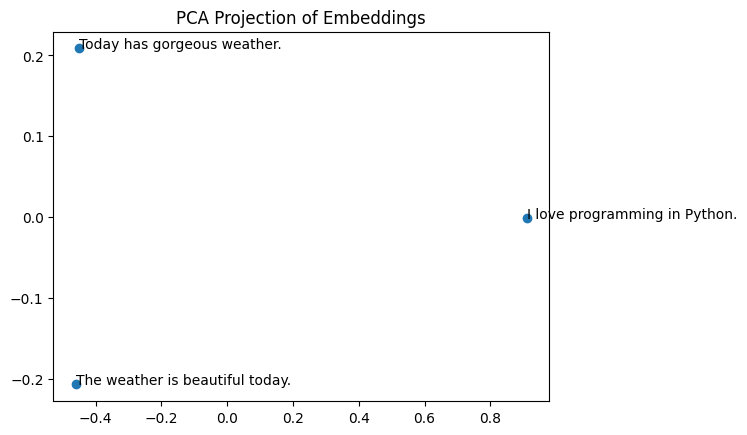

In [10]:
# Visualise the result
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
plt.scatter(reduced[:, 0], reduced[:, 1])
for i, sentence in enumerate(sentences):
    plt.annotate(sentence, (reduced[i, 0], reduced[i, 1]))
plt.title("PCA Projection of Embeddings")
plt.show()

# Store the embeddings in the vector database

In [11]:
# Create a list of dictionaries for DB insertion
data = [
    {"id": i, "embedding": vec.tolist()}  # Ensure vector is a list
    for i, vec in enumerate(embeddings)
]

# Insert the vectors into the collection
collection.insert(data=data)

# OPTIONAL: Create index if not already created
collection.create_index(
    field_name="embedding",
    index_params={
        "metric_type": "COSINE",
        "index_type": "IVF_FLAT",
        "params": {"nlist": 128}
    },
    index_name="idx"
)

collection.flush()
collection.load()

In [12]:
# 🔎 Now demonstrate vector DB retrieval with semantic search
print("\n🔁 VECTOR DATABASE RETRIEVAL DEMO")
query = "weather"
query_vector = model.encode([query])

# Search DB using the embedded query
results = collection.search(
    data=query_vector,
    anns_field="embedding",
    param={"metric_type": "COSINE"},
    limit=3,
    output_fields=["embedding"]  # optional if you want to view the matched vectors
)

# Mapping from id to original input text (stored in memory from `sentences`)
id_to_text = {i: sentence for i, sentence in enumerate(sentences)}

# Print matches
print(f"\n📌 Query term: '{query}'\n")
print("📥 Top matches returned by vector DB:\n")
for match in results[0]:
    match_id = match.id
    score = match.score
    matched_vector = match.entity.get("embedding")
    matched_text = id_to_text.get(match_id, "[Unknown]")

    print(f"🆔 ID: {match_id}")
    print(f"🧠 Text: {matched_text}")
    print(f"📏 Cosine Similarity Score: {score:.4f}")
    print(f"📊 First 5 vector values: {matched_vector[:5]}\n")

print("✅ Only semantically similar entries (e.g. weather-related) were returned.")
print("❌ Unrelated entries like 'I love programming in Python.' were filtered out due to low similarity.")



🔁 VECTOR DATABASE RETRIEVAL DEMO

📌 Query term: 'weather'

📥 Top matches returned by vector DB:

🆔 ID: 0
🧠 Text: The weather is beautiful today.
📏 Cosine Similarity Score: 0.6844
📊 First 5 vector values: [0.013072286732494831, 0.11939921975135803, 0.162684366106987, 0.07397012412548065, 0.027830185368657112]

🆔 ID: 1
🧠 Text: Today has gorgeous weather.
📏 Cosine Similarity Score: 0.6311
📊 First 5 vector values: [-0.012450693175196648, 0.12634028494358063, 0.15230560302734375, 0.048576489090919495, 0.013526065275073051]

🆔 ID: 2
🧠 Text: I love programming in Python.
📏 Cosine Similarity Score: 0.0227
📊 First 5 vector values: [-0.057617031037807465, 0.004262263886630535, -0.028153132647275925, 0.025197606533765793, -0.016505615785717964]

✅ Only semantically similar entries (e.g. weather-related) were returned.
❌ Unrelated entries like 'I love programming in Python.' were filtered out due to low similarity.


In [13]:
# Close the Milvus connection
collection.release()
utility.drop_collection(collection_name)